<a href="https://colab.research.google.com/github/sv650s/sb-capstone/blob/master/2019-06-23-DNN_128_128-word2vec5-prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DNN Prototype

Trying out a 2 layer network using word2vec embedding. Embedding was creating with word_context == 5
Recommendation that I read for NN is the number of neurons should not exceed 2/3 of the number of features which would be around 340 for 512 features

Since I have 2 layers in the network, I am choosing powers of 2 and giving each hidden layer 128 neurons

In [17]:
from google.colab import drive
import sys
drive.mount('/content/drive')
# add this to sys patch so we can import utility functions
DRIVE_DIR = "drive/My Drive/Springboard/capstone"
sys.path.append('drive/My Drive/Springboard/capstone')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from util import dict_util as du
from util import file_util as fu
from util import plot_util as pu
from util import keras_util as ku
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report
import os
import seaborn as sns


sns.set()

import logging
logging.basicConfig(level=logging.INFO)




In [0]:
DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
DATA_FILE = "review_body-word2vec5-111909-512-nolda.csv"
MODEL_NAME = "DNN_128_128"
LABEL_COLUMN = "star_rating"
EPOCH=100


In [0]:
df = pd.read_csv(f"{DRIVE_DIR}/data/{DATA_FILE}")
rating = df[LABEL_COLUMN]
df = df.drop(columns=["helpful_votes", "total_votes", "helpful_product", "star_rating"])

In [21]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511
0,-0.288502,-0.481055,0.258424,0.362731,0.475364,0.421039,0.014504,0.213545,-0.390066,0.103808,0.092057,-0.045284,0.178335,0.163173,-0.825025,-0.117711,0.193103,-0.039416,0.232813,-0.626957,0.255899,-0.086203,-0.112010,-0.049405,-0.168732,-0.066539,-0.313819,-0.177017,0.028803,-0.097103,0.623241,0.014126,0.023108,0.058664,-0.216553,0.400928,0.303050,-0.222227,-0.287176,0.037768,...,0.329862,0.034904,-0.214976,0.167887,-0.085614,-0.093523,-0.529687,0.326094,0.163124,-0.068303,-0.531376,-0.006876,-0.179367,0.017102,0.018383,-0.121967,0.012128,-0.409407,-0.597547,-0.159906,-0.358888,-0.042565,0.285005,0.432336,-0.005819,-0.093201,0.208513,-0.279186,-0.242795,0.565175,0.193389,-0.345230,-0.041291,0.063343,-0.230869,-0.018990,-0.462915,-0.762691,0.271782,-0.653218
1,0.173821,-0.214929,-0.098004,0.432866,0.370673,0.000804,-0.735449,0.162931,0.113988,0.468011,0.091182,-0.015925,-0.367213,-0.148326,-0.570235,0.235001,0.474639,0.056680,0.336305,-0.118116,0.086382,-0.023839,0.352665,0.201555,-0.232855,0.139960,-0.107633,-0.274393,-0.098784,0.033530,0.202761,-0.214515,-0.363571,0.180008,0.160661,0.698344,0.403793,-0.036676,-0.124082,-0.088976,...,0.558337,-0.285610,-0.147095,0.117567,0.064415,-0.074428,0.022359,0.361806,0.115827,-0.102381,-0.170256,0.033135,0.093055,0.162718,-0.243858,0.281852,0.290611,-0.160803,-0.242895,0.113361,-0.758359,0.122067,0.039228,0.199917,-0.438904,-0.207233,-0.046206,-0.307828,-0.336320,0.378690,0.133606,-0.374622,-0.360892,-0.394297,-0.168498,-0.262506,-0.958892,0.099089,0.487517,-0.307144
2,-0.257559,-0.065606,0.344815,0.411276,0.090839,0.738248,0.282006,0.331116,-0.213441,0.092032,-0.173409,-0.434767,0.065186,0.196101,-0.671928,-0.195213,0.074474,0.323334,0.292436,0.468960,-0.193369,0.157990,-0.180058,0.095284,-0.294818,-0.140939,-0.202958,-0.144758,-0.270722,0.155839,0.314211,-0.097944,0.396810,0.310496,-0.448204,0.575355,0.241816,-0.428021,-0.066452,0.207896,...,-0.253060,-0.023285,0.387593,-0.257498,-0.219196,0.463819,-0.047877,-0.002297,-0.023295,0.096966,0.185142,-0.053014,0.580751,0.230906,-0.090283,-0.549747,0.448878,-0.358442,-0.267432,0.062992,-0.650513,0.471424,-0.207576,0.421068,-0.340663,-0.287685,0.239766,-0.012972,-0.408097,0.380892,0.273857,-0.094201,0.245259,0.438028,-0.413395,0.425271,-0.417884,-0.886485,0.458968,-0.380352
3,-0.023537,0.186004,-0.018319,0.046002,0.285380,0.824158,0.240865,0.177934,-0.293685,0.369762,-0.286876,-0.115853,0.074393,-0.267145,-0.400384,0.067620,0.081379,0.260510,-0.002243,0.159411,0.212635,-0.261783,0.071453,-0.525530,0.149235,-0.563100,-0.378368,-0.396288,-0.265716,-0.028256,0.035099,-0.282228,0.121753,-0.244408,-0.323249,0.133777,0.099915,-0.073891,0.044732,0.229217,...,-0.164505,-0.436309,-0.089114,-0.515013,-0.356831,0.644965,0.151415,-0.040290,0.202163,0.065799,-0.013578,0.264860,0.562417,-0.322598,0.117282,-0.137634,0.454603,0.114935,-0.076333,0.362280,-0.349352,0.368029,0.062586,0.346775,-0.227782,-0.668857,0.477370,-0.349774,-0.566387,0.270867,0.076834,0.171872,0.258420,0.169574,-0.280809,0.322120,-0.102916,-0.606135,0.186568,-0.477317
4,-0.832218,0.451893,0.474038,-0.018249,-0.478648,0.178108,-0.472869,-0.532138,-0.491469,-0.466011,0.395096,-0.386877,-0.798011,-0.271923,-0.168703,0.567564,0.918460,-0.283334,0.052681,0.335400,0.102989,-0.569144,-0.027434,-0.390786,-0.411513,-0.004615,0.059425,0.129107,0.058133,0.178414,-0.222867,0.336164,0.079755,0.220411,0.184255,0.723972,0.306105,0.653465,-0.934595,-0.013150,...,0.484666,-0.181744,0.296147,0.775699,0.239380,-0.016156,0.329073,-0.023605,-0.197673,-1.308118,0.593427,0.109318,-0.387851,0.090579,-0.265281,-0.083823,0.498955,-0.115021,0.705434,0.536024,0.319468,0.083369,-0.067807,-0.206901,0.215812,0.166634,0.071825,0.669192,0.043907,0

In [22]:
rating.head()

0    5
1    5
2    5
3    5
4    3
Name: star_rating, dtype: int64

In [0]:
model = Sequential()

model.add(Dense(128, input_shape=(df.shape[1],), kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(128, kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(5, activation='relu'))
model.add(Activation('softmax'))
model.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               65664     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
activation_4 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512       
_________________________________________________________________
activation_5 (Activation)    (None, 128)               0         
__________

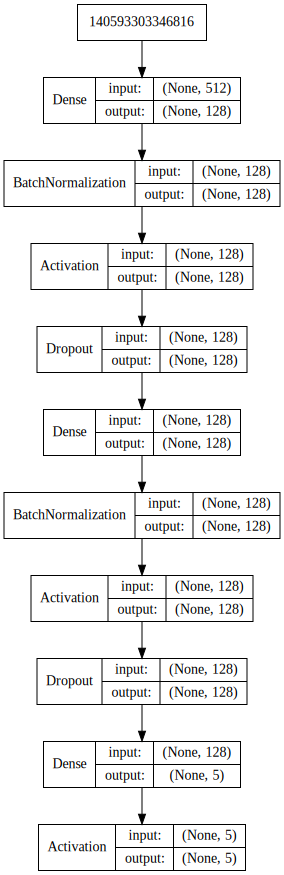

In [25]:
SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

In [26]:
# one hot encode rating
print(rating.shape)
print(type(rating))
y = OneHotEncoder().fit_transform(rating.values.reshape(len(rating), 1)).toarray()
y

(111909,)
<class 'pandas.core.series.Series'>


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.]])

In [0]:
x_train, x_test, y_train, y_test = train_test_split(df, y, random_state=1)

In [28]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)


# use our model wrapper the wrap the model so we can save things for later
mw = ku.ModelWrapper(model=model, 
                     name=MODEL_NAME, 
                     label_name=LABEL_COLUMN, 
                     data_file=DATA_FILE, 
                     embedding="word2vec")


network_history = mw.fit(x_train, y_train,
                      batch_size=128,
                      epochs=100,
                      verbose=1,
                      validation_split=0.2,
                      callbacks=[early_stop])

W0730 00:44:28.377286 140594426595200 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 67144 samples, validate on 16787 samples
Epoch 1/100
67144/67144 [==============================] - 6s 89us/step - loss: 1.2293 - acc: 0.5389 - val_loss: 1.0688 - val_acc: 0.6209
Epoch 2/100
67144/67144 [==============================] - 5s 77us/step - loss: 1.0674 - acc: 0.6112 - val_loss: 0.9947 - val_acc: 0.6302
Epoch 3/100
67144/67144 [==============================] - 5s 73us/step - loss: 1.0071 - acc: 0.6211 - val_loss: 0.9609 - val_acc: 0.6413
Epoch 4/100
67144/67144 [==============================] - 5s 73us/step - loss: 0.9829 - acc: 0.6294 - val_loss: 0.9435 - val_acc: 0.6460
Epoch 5/100
67144/67144 [==============================] - 5s 74us/step - loss: 0.9650 - acc: 0.6341 - val_loss: 0.9343 - val_acc: 0.6480
Epoch 6/100
67144/67144 [==============================] - 5s 73us/step - loss: 0.9547 - acc: 0.6394 - val_loss: 0.9254 - val_acc: 0.6506
Epoch 7/100
67144/67144 [==============================] - 5s 74us/step - loss: 0.9464 - acc: 0.6413 - val_loss: 0.9163 - 

In [31]:
mw.evaluate(x_test, y_test)
print("Accuracy: %.2f%%" % (mw.scores[1]*100))


Running model.evaluate...
27978/27978 [==============================] - 1s 36us/step
Running model.predict...
Unencode predictions...
Generating confusion matrix...
Calculating ROC AUC...
Getting classification report...
Accuracy: 66.65%


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


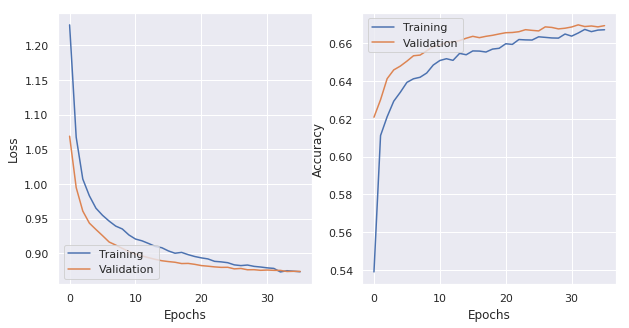

In [32]:


pu.plot_network_history(mw.network_history)

In [33]:
mw.confusion_matrix

array([[ 3230,     0,   265,    89,   291],
       [ 1024,     0,   382,   168,   313],
       [  670,     0,   624,   582,   684],
       [  306,     0,   363,  1121,  2847],
       [  408,     0,   231,   708, 13672]])

In [34]:
mw.classification_report

'              precision    recall  f1-score   support\n\n           1       0.57      0.83      0.68      3875\n           2       0.00      0.00      0.00      1887\n           3       0.33      0.24      0.28      2560\n           4       0.42      0.24      0.31      4637\n           5       0.77      0.91      0.83     15019\n\n    accuracy                           0.67     27978\n   macro avg       0.42      0.45      0.42     27978\nweighted avg       0.59      0.67      0.62     27978\n'

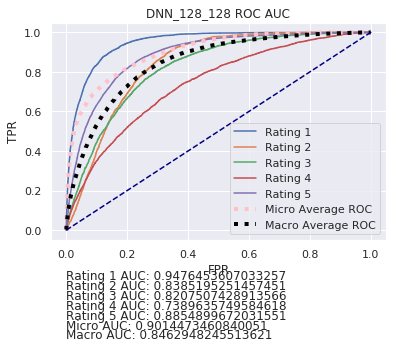

In [35]:
pu.plot_roc_auc(mw.name, mw.roc_auc, mw.fpr, mw.tpr)

# Save off various files

In [36]:
mw.save(DRIVE_DIR, append_report=True)
mw.get_report().to_df()

description: review_body-word2vec5-111909-512-nolda-DNN_128_128-512-star_rating
Saving model file: drive/My Drive/Springboard/capstone/models/review_body-word2vec5-111909-512-nolda-DNN_128_128-512-star_rating-model.h5
Saving network history file: drive/My Drive/Springboard/capstone/models/review_body-word2vec5-111909-512-nolda-DNN_128_128-512-star_rating-history.pkl
Saving to report file: drive/My Drive/Springboard/capstone/reports/2019-07-30-dl_protype-report.csv
Loading to append to: drive/My Drive/Springboard/capstone/reports/2019-07-30-dl_protype-report.csv
Saving report file...


,accuracy,classification_report,confusion_matrix,description,embedding,file,fpr,loss,max_sequence_length,model_file,model_name,network_history_file,roc_auc,status,status_date,test_examples,test_features,tokenizer_file,tpr,train_examples,train_features,train_time_min
0,0.666488,"{""1"": {""precision"": 0.5728981908478183, ""recal...","[[3230, 0, 265, 89, 291], [1024, 0, 382, 168, ...",review_body-word2vec5-111909-512-nolda-DNN_128...,word2vec,review_body-word2vec5-111909-512-nolda.csv,"{""0"": [0.0, 0.0, 0.0, 0.0, 0.0, 8.297722275235...",0.873364,512.0,drive/My Drive/Springboard/capstone/models/rev...,DNN_128_128,<keras.callbacks.History object at 0x7fde6cf04...,"{""auc_1"": 0.9476453607033257, ""auc_2"": 0.83851...",success,2019-07-30 00:56:14,27978.0,512.0,None,"{""0"": [0.0, 0.00025806451612903227, 0.00077419...",83931.0,512.0,3.56


In [38]:
# test if report is generated
loaded = pd.read_csv(mw.report_file, quotechar="'")
loaded

,accuracy,classification_report,confusion_matrix,description,embedding,file,fpr,loss,max_sequence_length,model_file,model_name,network_history_file,roc_auc,status,status_date,test_examples,test_features,tokenizer_file,tpr,train_examples,train_features,train_time_min
0,0.680697,"{""1"": {""precision"": 0.6267168391345249, ""recal...","[[3331, 58, 226, 48, 305], [990, 62, 364, 144,...",amazon_reviews_us_Wireless_v1_00-preprocessed-...,300.0,drive/My Drive/Springboard/capstone/data/amazo...,"{""0"": [0.0, 0.0, 0.0, 0.0, 0.0, 4.159214740257...",0.832744,186.0,drive/My Drive/Springboard/capstone/models/ama...,GRU_bi1layer_attention,<keras.callbacks.History object at 0x7fd96547c...,"{""auc_1"": 0.9550504449437365, ""auc_2"": 0.86529...",success,2019-07-30 00:41:39,28011.0,186.0,<keras_preprocessing.text.Tokenizer object at ...,"{""0"": [0.0, 0.00025201612903225806, 0.00151209...",84032.0,186.0,8.67
1,0.666488,"{""1"": {""precision"": 0.5728981908478183, ""recal...","[[3230, 0, 265, 89, 291], [1024, 0, 382, 168, ...",review_body-word2vec5-111909-512-nolda-DNN_128...,word2vec,review_body-word2vec5-111909-512-nolda.csv,"{""0"": [0.0, 0.0, 0.0, 0.0, 0.0, 8.297722275235...",0.873364,512.0,drive/My Drive/Springboard/capstone/models/rev...,DNN_128_128,<keras.callbacks.History object at 0x7fde6cf04...,"{""auc_1"": 0.9476453607033257, ""auc_2"": 0.83851...",success,2019-07-30 00:56:12,27978.0,512.0,NaN,"{""0"": [0.0, 0.00025806451612903227, 0.00077419...",83931.0,512.0,3.56
